In [4]:
#Get imports out of the way
import pandas as pd
import numpy as np

#imports to visulize the tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tree_plots import plot_decsion_bondary, plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris



# Trees

Tree based models are conceptually simple yet incrediably powerfully, when coupled with some other ideas, namely ensemble they really shine. Trees plus ensembles form the basis of some of the most succesfull machine learning algorithms like Random Forest, XGBoost and LightGBM.  Tree allow for both classification and regression, aswell as having the ability to handle missing values, this versatility makes them exteremly usefull. 


![](https://mapr.com/blog/predicting-loan-credit-risk-using-apache-spark-machine-learning-random-forests/assets/blogimages/creditdecisiontree.png)


To build a tree we essentially ask a series of questions that results in yes or no anwsers, allowing us to split the dataset. If we ask enough questions eventually we'll be able to split the data into clear categoires. However the goal is to classify all of the data with the least amounts of splits (or questions) in our tree, which means asking the most relevant questions at each point in the tree.

# Gini Impurity

How do we decide on what questions to ask or in other words what features to split on? This is where impuriy comes in, it gives us a measure of how 'good' our splits are. Intuitively a split will be good if it effectivley seperates one class from others, and a split will be bad it doesn't seperate any classes at all. Other measures of impurity such as entropy also exist, but since gini is simpler and give similar results we'll stick to it.


The Gini impurity is a probabilstic measurement of impurity, it tells us the proablity of obtaining two different outputs. 

* If $ p_i $ is the probality of picking item $ i $ then $ 1 - p_i $ is the probablity of not picking item $  i $.
* Therefore $ (1 - p_i)p_i $ is the probablity of picking two different items.
* So when we take all $ C $ items into acount the probablity of picking different items is $ \sum_{i=1}^{j} p_{i}(1-p_i) $
 
This formular can be rearranged into the final formualr for gini coeffient.

$$ Gini(C) = 1- \sum_{i=1}^{C}{p_{i}}^{2} $$

Gini impurity is highest when there is a equal number of classes in a set, and it's lowest when there is a single class in a set.  The gini function above works we'll when we want to measure impurity in a single group, but at splits in the tree we have two groups? The solution is to take the average gini for the splits.

$$ Gini_{split} = \sum_{i=1}^{C} \frac{n_i}{n} Gini(i) $$

Where:

* $ n_i $ is the number of records at the child node $ i $
* $ n $ is the total number of records at the parent node

So it's like the gini function again but using weighted average for each group in the split. 

#  Visualization

It's all great having a really accurate model but it's nice if we know why it makes the decisions it does, one great thing about decsion trees is that they are easy to visulize, so we can find out. We'll use the sklearn version of the CART tree and only use 2 features and limit the max depth to prevent our tree plots growing to unweildly. 

In [6]:
#Load data
iris=load_iris()
df=pd.DataFrame(iris.data, columns=iris.feature_names)
y=iris.target
X = df.iloc[:,[0,3]].values

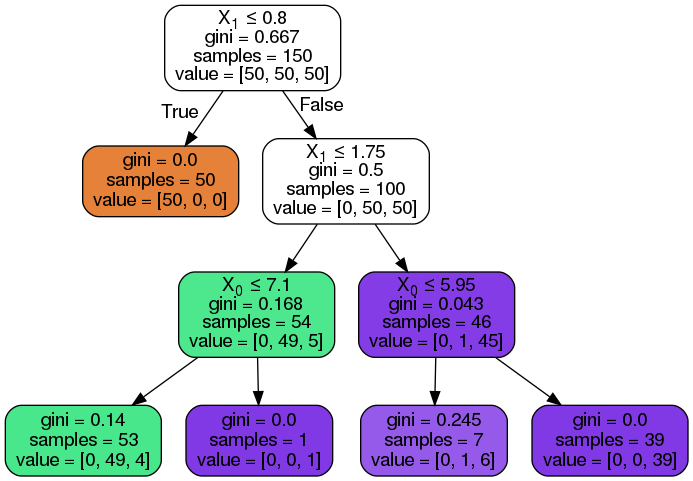

In [7]:
dtree=DecisionTreeClassifier(max_depth=3)
dtree.fit(X,y)
Image(plot_tree(dtree))

We can see that at each decision node, the tree splits on one of the features $ X_0$ or $ X_1 $ and this results in two children nodes.  A node is a leaf node if either it has a pure classes in it or the max depth of the tree has been reached. Nodes with pure classes have a gini of 0.



# Decision Boundaries

Another type of visulization is of the tree's decision boundarys, this gives us a sense of how trees partition the feature space. From looking at the plots bellow we can see that the decision boundaries are composed of straight lines. And indeed each decision node in a tree corresponds to a straight line in the decision plane.  We use lines to divide the items in our plane until we're left with either pure groups or have run out of lines to draw (we've reached the trees max depth). Finally we'd look at one of the retangularish areas left and depending on if it's classification or regression we can take the mode or mean to get our final prediction.

Text(0.5,1,'Deeper Tree')

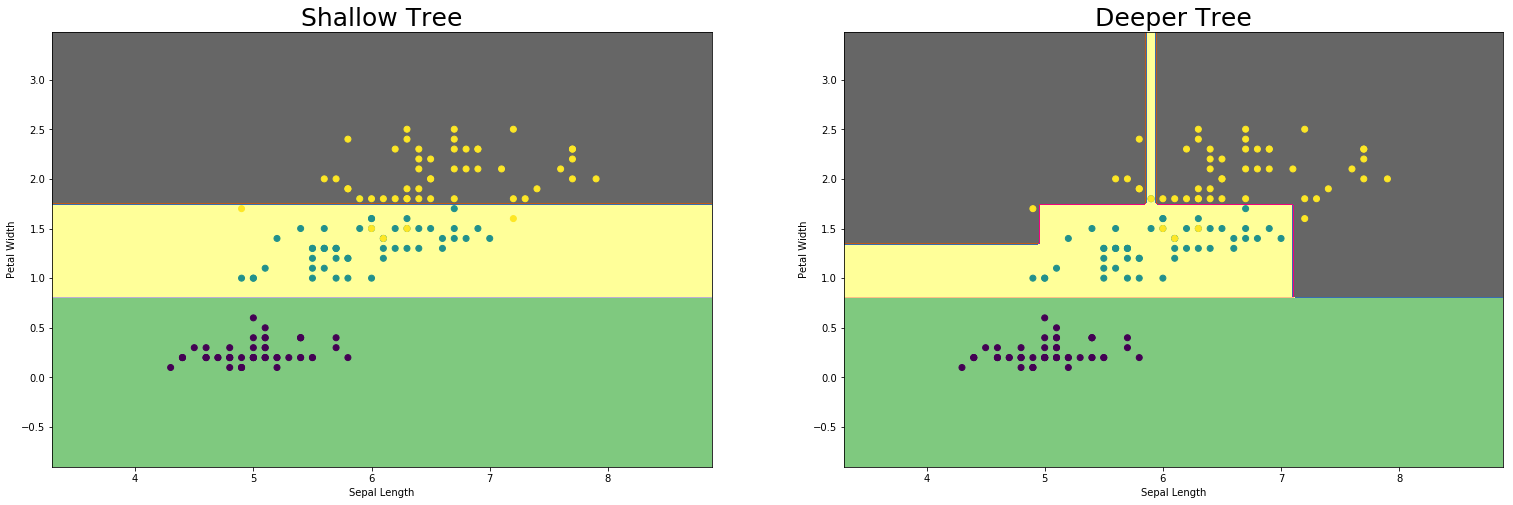

In [14]:
fig, axes = plt.subplots(1,2,figsize= (26,8))
#Shallow tree
dtree=DecisionTreeClassifier(max_depth=2)
dtree.fit(X,y)
plot_decsion_bondary(dtree,X,y,axes[0], xlabel='Sepal Length',ylabel='Petal Width')
axes[0].set_title("Shallow Tree",size=25)
#Deeper tree
dtree=DecisionTreeClassifier(max_depth=10)
dtree.fit(X,y)
plot_decsion_bondary(dtree,X,y,axes[1], xlabel='Sepal Length',ylabel='Petal Width')
axes[1].set_title("Deeper Tree",size=25)

As we increase the max depth of the tree the decsion boundaries get increasingly complex, being composed of more and more lines. This can lead to increased accuracy on our training set, but often as a result of overfitting. This means the the algorithm won't generalize well to our testing dataset. 




# Feature Importance

All of the decision trees in sklearn also have `.feature_importances_` property which let's us quickly see which features were most usefull for the decision tree. Often if you don't know where to start with a dataset it can be a good idea to fit a tree based model on it just to inspect the feature importances.

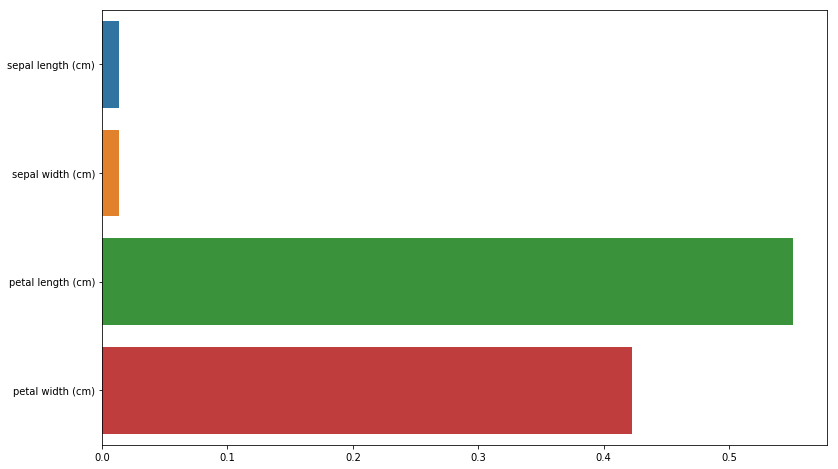

In [42]:
dtree = DecisionTreeClassifier(random_state=4)
dtree.fit(df,y)
fig,ax = plt.subplots(figsize= (13,8))
sns.barplot(x= dtree.feature_importances_,y = df.columns)

# Ensemble Methods

A single tree by itself isn't very powerful, it's prone to both under and overfitting depending on how deep or shallow we grow it, however thankfully a number of methods have been devised to circumvent this. Two methods which really complement trees are bagging and boosting, both of which are ensemble methods.

With bagging we randomly sample $ n $ sections of the dataset with replacement and then use each sample to train a model on. At the end of training you give each trained model a equal vote and use the most popular anwser for the prediction (by either taking the mean or mode). If we combine bagging with decision trees we almost get a Random Forest, the only missing detail being in the random sample it should only contain a random subset of the features. This process of bagging helps to reduce variance and gives a more consitent output prediction. With respect to random forest this helps our models generalize better to the real world. Bagging is and example of a paralel ensemble method since we train many different trees in parallel and then use them to make a prediction.

In contrast to bagging there is another method called boosting which involves training models sequentially. In boosting we use the mistakes from previous model to help guide the later models. To start,each sample in the dataset has a uniform chance of being sampled,  however after training a model the sampling weights are redistibuted. We look at which items are misclassified and increase the chance of those item being sampled. We then train another model on the resampled data, and repeat this procedure. Therefore each subsqeuent model focuses on the mistake of the previous models. Finally for the prediction stage we take the weight average of all of the models estimates. The estimates are weighted by the models accuracy on the training data.

# Resources

* [A Pratical Guide To Tree Based Models](https://sadanand-singh.github.io/posts/treebasedmodels/)
* [Diffrences between bagging and boosting](https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/)
* [Creating and Visualizing Decision Trees With Python](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)
* [Tree Decision Boundaries](https://shapeofdata.wordpress.com/2013/07/02/decision-trees/)
* [A simple clear explantion of the gini impurity ](https://stats.stackexchange.com/questions/308885/a-simple-clear-explanation-of-the-gini-impurity)
* [Gini Impuriy Derviation](https://stats.stackexchange.com/questions/175087/basic-gini-impurity-derivation)